### **Image Classification of Common Food Ingredients**

Developing a machine learning model to recognize and classify images of common food ingredients, including meat (daging), vegetables (tomat, kentang, wortel, brokoli, bayam), tofu (tahu), tempe, eggs (telur), shrimp (udang), fish (ikan), and chicken (ayam), using Convolutional Neural Networks (CNN) in TensorFlow..



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Libraries**




In [2]:
import os
import shutil
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

### **Preparing Dataset**

Data splitting for training and validation.

In [ ]:
# Path to the dataset folder
dataset_dir = '/content/drive/My Drive/dataset'

# Create folders for training and validation datasets
train_dir = os.path.join(dataset_dir, "training")
val_dir = os.path.join(dataset_dir, "validation")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define classes based on the dataset
classes = [
    "Daging", "Tomat", "Kentang", "Tahu", "Wortel",
    "Telur", "Udang", "Brokoli", "Ayam", "Bayam",
    "Ikan", "Tempe"
]

In [ ]:
# Loop through each class folder and split the dataset (80% train, 20% validation)
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    files = os.listdir(class_path)
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    # Create directories for training and validation
    train_class_dir = os.path.join(train_dir, class_name)  # Folder for this class in the training set
    val_class_dir = os.path.join(val_dir, class_name)      # Folder for this class in the validation set

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copy files to the training and validation directories
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(train_class_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_path, file), os.path.join(val_class_dir, file))

Dataset is successfully split and saved into the respective directories.

In [ ]:
# Inspect the dataset after splitting
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    print(f"Class '{class_name}':")
    print(f" - Train set contains {len(os.listdir(train_class_dir))} files.")
    print(f" - Validation set contains {len(os.listdir(val_class_dir))} files.")

Class 'Daging':
 - Train set contains 330 files.
 - Validation set contains 83 files.
Class 'Tomat':
 - Train set contains 325 files.
 - Validation set contains 82 files.
Class 'Kentang':
 - Train set contains 307 files.
 - Validation set contains 77 files.
Class 'Tahu':
 - Train set contains 316 files.
 - Validation set contains 80 files.
Class 'Wortel':
 - Train set contains 312 files.
 - Validation set contains 78 files.
Class 'Telur':
 - Train set contains 328 files.
 - Validation set contains 83 files.
Class 'Udang':
 - Train set contains 326 files.
 - Validation set contains 82 files.
Class 'Brokoli':
 - Train set contains 320 files.
 - Validation set contains 81 files.
Class 'Ayam':
 - Train set contains 320 files.
 - Validation set contains 80 files.
Class 'Bayam':
 - Train set contains 301 files.
 - Validation set contains 76 files.
Class 'Ikan':
 - Train set contains 321 files.
 - Validation set contains 81 files.
Class 'Tempe':
 - Train set contains 320 files.
 - Validation 

Data augmentation.

In [4]:
# Define paths for training and validation datasets
train_dir = '/content/drive/My Drive/dataset/training'
val_dir = '/content/drive/My Drive/dataset/validation'

# Data Augmentation for Training (used to enhance training data with random transformations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Data Augmentation for Validation (without augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 3826 images belonging to 12 classes.
Found 963 images belonging to 12 classes.


In [ ]:
# Jika menggunakan ImageDataGenerator dan flow_from_directory
class_indices = train_generator.class_indices
print(class_indices)

{'Ayam': 0, 'Bayam': 1, 'Brokoli': 2, 'Daging': 3, 'Ikan': 4, 'Kentang': 5, 'Tahu': 6, 'Telur': 7, 'Tempe': 8, 'Tomat': 9, 'Udang': 10, 'Wortel': 11}


### **Build Model**

Base model.

In [ ]:
# Load MobileNetV2 base model with pre-trained weights from ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom layers on top of MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping and learning rate scheduler to improve training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

Train the base model.

In [ ]:
# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)

# Save the trained model to Google Drive
model.save('/content/drive/My Drive/classifier_base.h5')
print("Model saved to Google Drive!")

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.4973 - loss: 1.6987 - val_accuracy: 0.8048 - val_loss: 0.6054 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 74s 274ms/step - accuracy: 0.7551 - loss: 0.7518 - val_accuracy: 0.7840 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 83s 279ms/step - accuracy: 0.7693 - loss: 0.7356 - val_accuracy: 0.8204 - val_loss: 0.5628 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 68s 275ms/step - accuracy: 0.7925 - loss: 0.6356 - val_accuracy: 0.8017 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 67s 272ms/step - accuracy: 0.7970 - loss: 0.6084 - val_accuracy: 0.8183 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 68s 275ms/step - accuracy: 0.8091 - loss: 0.5974 - val_accuracy: 0.8069 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 81s 275ms/step - accuracy: 0.8

Model saved to Google Drive!


Fine-tuned model.

In [ ]:
# Unfreeze the last few layers of MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze most of the early layers
    layer.trainable = False

# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fine-tuning the model
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

# Save the fine-tuned model
model.save('/content/drive/My Drive/classifier_finetuned.h5')
print("Fine-tuned model saved to Google Drive!")

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 98s 328ms/step - accuracy: 0.7465 - loss: 0.7914 - val_accuracy: 0.8224 - val_loss: 0.6522 - learning_rate: 1.0000e-04
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 72s 295ms/step - accuracy: 0.8290 - loss: 0.5352 - val_accuracy: 0.8214 - val_loss: 0.6760 - learning_rate: 1.0000e-04
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 69s 279ms/step - accuracy: 0.8546 - loss: 0.4585 - val_accuracy: 0.8089 - val_loss: 0.8742 - learning_rate: 1.0000e-04
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 86s 298ms/step - accuracy: 0.8849 - loss: 0.3564 - val_accuracy: 0.8339 - val_loss: 0.7304 - learning_rate: 1.0000e-04
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 73s 299ms/step - accuracy: 0.8805 - loss: 0.3526 - val_accuracy: 0.8380 - val_loss: 0.7426 - learning_rate: 1.0000e-04
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 69s 280ms/step - accuracy: 0.8933 - loss: 0.3289 - val_accuracy: 0.8297 - val_loss: 0.7285 - learning_rate: 1.0000e-04
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 69s 28

Fine-tuned model saved to Google Drive!


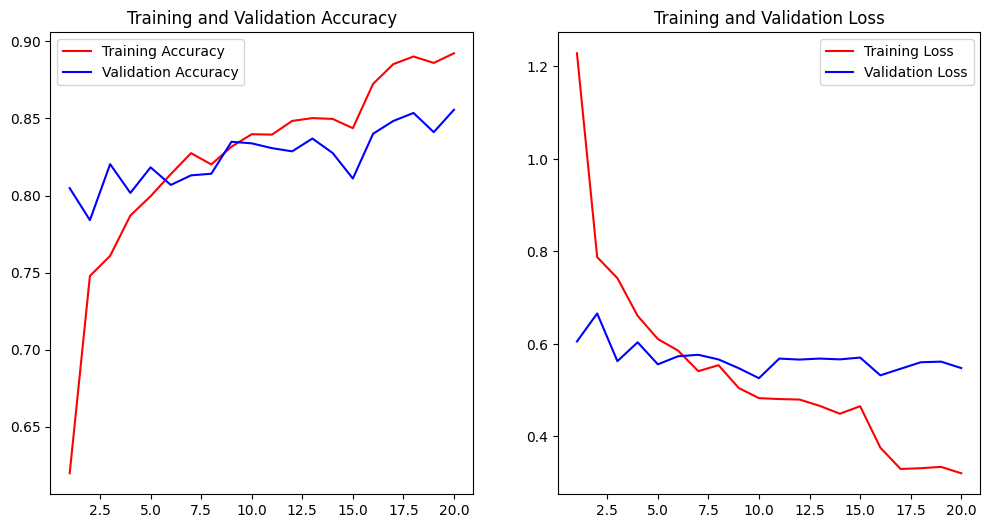

In [ ]:
# Plot training dan validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


### **Prediction**

In [14]:
# Load the fine-tuned model
model = tf.keras.models.load_model('/content/drive/My Drive/classifier_finetuned.h5')

# Mapping class indices to class names
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Function to load recipes from a JSON file
def load_recipes(file_path):
    with open(file_path, 'r') as f:
        recipes = json.load(f)
    return recipes

# Function to predict a single image
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    return class_names[predicted_class], confidence

# Function to provide recipe recommendations based on predicted class
def recommend_recipe(predicted_class, recipes):
    predicted_class = predicted_class.strip().lower()  # Remove extra spaces and convert to lowercase
    print(f"Predicted class after strip and lowercase: {predicted_class}")  # Debugging

    for recipe in recipes:
        recipe_name = recipe["Nama Resep"].strip().lower()  # Remove extra spaces and convert to lowercase

        # Partial matching: check if the recipe name contains the predicted class name
        if predicted_class in recipe_name:
            return recipe

    return None

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the path of the uploaded image

# Predict the image
predicted_class, confidence = predict_image(image_path)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# Load recipes from the JSON file
recipes = load_recipes('/content/drive/My Drive/recipes.json')  # Replace with your recipes.json file path

# Provide recipe recommendations
recipe_recommendation = recommend_recipe(predicted_class, recipes)
if recipe_recommendation:
    print(f"Recipe Recommendation: {recipe_recommendation['Nama Resep']}")
    print(f"Age Category: {recipe_recommendation['Kategori Usia']}")
    print(f"Energy: {recipe_recommendation['Energi (kkal)']} kcal")
    print(f"Protein: {recipe_recommendation['Protein (g)']} g")
    print(f"Fat: {recipe_recommendation['Lemak (g)']} g")
    print(f"Carbohydrates: {recipe_recommendation['Karbohidrat (g)']} g")
    print(f"Ingredients: {recipe_recommendation['Bahan']}")
    print(f"Cooking Instructions: {recipe_recommendation['Cara Memasak']}")
else:
    print("No recipe found for this class.")

Saving test12.jpeg to test12.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Brokoli
Confidence: 1.00
Predicted class after strip and lowercase: brokoli
Recipe Recommendation: Cah Brokoli Sosis
Age Category: > 1 tahun (untuk 2 porsi)
Energy: 157.3 kcal
Protein: 6.9 g
Fat: 8.1 g
Carbohydrates: 16.5 g
Ingredients: 1. 100 gr brokoli, potong-potong, 2. 100 gr wortel, potong-potong, 3. 4 bh sosis sapi, iris, 4. 1 bh bawang bombay, iris, 5. 4 siung bawang putih, iris, 6. 1/2 sdt garam, 7. 1/2 sdt gula, 8. Air secukupnya, 9. Margarin secukupnya
Cooking Instructions: 1. Panaskan margarin dan tumis bawang putih dan bawang bombay sampai harum, 2. Tambahkan air, tunggu hingga mendidih, kemudian tambahkan garam dan gula, 3. Masukkan sosis dan wortel, tunggu sampai wortel empuk, 4. Masukkan brokoli, aduk sampai matang. Sajikan.
